# **Desafio de ciência de dados Radix**
# **NYC subway dataset**

|Análise e modelagem  de fluxo de passageiros no metrô de Nova york|
|:-----------------------------------------------|
|**Autor:** Rodrigo Gomes Dutra|
|**Data:** maio de 2022|

|SUMÁRIO|
|:------------------|
|[**1. Introdução**](#intro)|
|[**2. Objetivo**](#obj)|
|[**3. Dados**](#dados)|
|[3.1 Análise descritiva](#desc)|
|[**4. Pré-processamento**](#pre)|
|[**5. Análise exploratória de dados**](#eda)|
|[5.1 Análise da série temporal e auto-correlação](#ti_ana)|
|[5.2 Teste de estacionaridade em sentido amplo](#test)|
|[5.3 Análise de covariantes](#cov)|
|[**6. Modelagem**](#modelos)|
|[6.1 ARIMA](#arima)|
|[6.2 LightGBM](#lgbm)|
|[6.3 Prophet](#prop)|
|[6.4 Regressão linear simples](#linear)|
|[6.5 Entendendo o melhor modelo e importância das features](#linear)|
|[**7. Considerações finais**](#conclusao)|
|[7.1 Perpectivas ](#perspectivas)|

## 1. Introdução <a name=intro></a>

Nesse case será analisado o dataset do metrô de Nova york, e o objetivo definido será prever a série temporal do número de passageiros para a proxima semana, realizando o forecasting por dia, dessa forma os modelos finais deverão ser capazes de entregar 7 dias de previsão de uma vez só, o que é chamado de previsão de vários passos.

A Metropolitan Transportation Authority (MTA), é reponsável por gerir o metrô de Nova York, realizando auditorias para computar a quantidade de passageiros que utiliza o sistema de transporte, a fim de averiguar faturamento, fluxo de passageiros, e necessidades de manutenção, entre outra tarefas associadas à gestão do metrô. No presente relatório, analisamos um conjunto de dados obtido da MTA, que traz informações das auditorias realizadas nas catracas.

O nosso conjunto de dados possui as seguintes entradas:

|   Entrada   |   Descrição  |
|:---------------------------------------:|:------------:|
|   `CA`   |  Control Area (A002), é a área de controle de acesso dos passageiros|
| `UNIT` | Remote Unit for a station (R051), unidade remota para determinada estação;|
|`SCP`| Subunit Channel Position (02-00-00), representa o endereço específico de um aparelho, usualmente catraca.|
|  `STATION`|Representa a estação onde o aparelho se encontra; |
| `LINENAME` | Representa as linhas que podem ser embarcadas na respectiva estação. Normalmente cada linha é representadas por um único caractere, e.g. LINENAME 456NQR significa que os tréns 4, 5, 6, N, Q, e R passam por aquela estação |
|   `DIVISION`  | Representa a "linha" que a estação era originalmente pertencente. BMT - Brooklyn–Manhattan Transit Corporation, IRT - Interborough Rapid Transit Company, ou IND - Independent Subway System; |
|`TIME ` |representa o dia e hora de um evento de auditoria (AA-MM-DD hh:mm:ss);|
|   `DESc`  |   identifica o tipo de auditoria realizada, se REGULAR ou não (normalmente ocorrendo a cada 4 horas). |
|   `ENTRIES`  |   Valor cumulativo de entradas registradas pela catraca; |
|   `EXIST`  |   Valor cumulativo de saídas registradas pela catraca.|

O estudo do fluxo de usuários pode auxiliar, por exemplo, no entendimento dos melhores dias para fazer manutenção, qual o faturamento mensal de cada estação, o intervalo de manutenção de cada estação ou linha de trem, entre outras motivações. Nesse contexto, o relatório divide-se em:

- Engenharia de variáveis e pré-processamento:

Aqui realizamos um processo de reestruturação do dataset, filtrando para uma área de controle e subunidade específica, modificando o intervalo para diário, removendo valores duplicados, verificando valores inconsistentes, realizar reamostragem dos dados, etren outros.

- Análise exploratória

Nessa etapa respondemos algumas perguntas que podem ser relevantes para a gestão do metrô, ou mesmo para seus usuários. Como volume de tráfego por estação, dias com maior quantidade de usuários. Periodicidade do tráfego, etc.

- Modelagem

Entender as características de cada estação, área de controle, etc é de fundamental importância, porém também é muito relevante conseguir prever o tráfego de usuários para realizar planejamentos financeiros, técnicos, etc. Desse modo, criamos alguns modelos com o objetivo de realizar essa previsão, comparando métricas para avaliar a qualidade dos mesmo.

## 2. Objetivo <a name=obj></a>

Esse case tem como objetivo definir uma metodologia para prever o fluxo total de uma estação especifica, para 7 dias na frente, utilizando um ano especifico para análise. Para definir a estação, iremos escolher a estação com maior trafico acumulado, assim para isso teremos que primeiro analisar a nossa base de dados para descobri-la.

Nesse case o fluxo total pode ser definido como a soma de entradas e saídas em um certo período de tempo, como será analisado por dia, o fluxo total será a soma de passageiros que entram e saem da estação selecionada no dia.

In [269]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import moment
from IPython.display import display, Image, HTML

import statsmodels
import plotly.express as px

import pmdarima as pm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # Feriados americanos
from tqdm import tqdm

import plotly.graph_objects as go

import pycountry_convert as pc
from scipy.signal import find_peaks

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pickle

from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
import os
import warnings
warnings.filterwarnings('ignore')

## 3. Dados <a name=dados></a>
### 3.1 Análise descritiva <a name=desc></a>

Para entendermos melhor os dados, realizamos uma primeira análise descritiva dos mesmos, para assim definir os passos necessários na parte de engenharia de dados.
Dessa forma iremos utilizar o dataset de `2010`, para montar a metodologia que iremos utilizar com todos os dados.

In [2]:
base_path = 'Dataset-Prova'
folders   = os.listdir(base_path)
df = pd.read_csv(f'{base_path}/2010.csv/2010.csv', parse_dates = ['time'])

In [3]:
def display_side_by_side(dfs:list, captions:list,show_caption=True):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    if show_caption:
        combined = dict(zip(captions, dfs))
        for caption, df in combined.items():
            output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
            output += "\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
    else:
        for df in dfs:
            output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
            output += "\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
    display(HTML(output))

In [4]:
df.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0


In [5]:
display_side_by_side([df.describe(), df.describe(include=['O', 'category']), df[['time']].describe()],captions=None,show_caption=False)

De partida, é possível ver que há valores negativos de entrada e saída, o que deve ser considerado como algum erro de medição, e portanto deve ser tratado. Também verificamos que as auditorias se iniciam em 17/04/2010, e continuam até o final do ano.

Abaixo, calculamos a contagem de frequência para as coluas categóricas, mostrando os 10 itens mais frequentes:

In [6]:
df_ca = pd.DataFrame(df['ca'].value_counts().head(10))
df_unit = pd.DataFrame(df['unit'].value_counts().head(10))
df_scp = pd.DataFrame(df['scp'].value_counts().head(10))
df_station = pd.DataFrame(df['station'].value_counts().head(10))
df_linename = pd.DataFrame(df['linename'].value_counts().head(10))
df_division = pd.DataFrame(df['division'].value_counts().head(10))
df_desc = pd.DataFrame(df['desc'].value_counts().head(10))

display_side_by_side([df_ca, df_unit, df_scp,df_station, df_linename, df_division,df_desc],captions=None,show_caption=False)

,ca
N208,62276
R203,61370
R204,60900
R158,60795
N103,59526
PTH08,42260
PTH05,39151
PTH03,38193
R610,35277
PTH07,35152


É importante também verificar se existem valores ausentes no dataframe:

In [7]:
df.isna().sum()

time            0
ca              0
unit            0
scp             0
station     10148
linename    10148
division    10148
desc            0
entries         0
exits           0
dtype: int64

Dos 7420384 registros, 10148 não possuem dados de station, linename ou division. Não identificamos um tratamento que possa ser feito para atribuir valores aos mesmos, portanto, os removeremos da base a ser analisada.

## 4. Pré-processamento <a name=pre></a>

Dado o objetivo do case, agora devemos processar os dados para selecionar somente uma estação e após isso realizar o tratamento desses dados nas etapas:
1. Filtrar por auditoria REGULAR
1. Verificar e remover valores duplicados
1. Filtrar por ca e scp, obter entries e exits por intervalo
1. Substituir valores de intervalos maiores que 1 dia e remover entries e exits acumulados
1. Fazer resample por dia e substituir nulos pelos valor da semana anterior
1. Criar variáveis de ano, mês, dia, hora, feriado e dia da semana, e variável de tráfego

__1. Filtrar por auditoria REGULAR__
Como o maior número de registros em auditoria são regulares optou-se por selecioná-las para seguir com a análise

In [8]:
def regular_data(df):
    data = df.copy()
    return data[data['desc']=='REGULAR'].reset_index(drop=True)

In [9]:
df1 = regular_data(df)
df1.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0


__2. Verificar e remover valores duplicados__

In [10]:
def duplicated_rows(df, verbose=True):
    data = df.copy()
    if verbose: print('A quantidade de linhas duplicadas a serem removidas é:',df.duplicated().sum())
    data.drop_duplicates(inplace=True)
    return data.reset_index(drop=True)

In [11]:
df2 = duplicated_rows(df1)
df2.head()

A quantidade de linhas duplicadas a serem removidas é: 30035


,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0


__3. Filtrar por ca e scp (com entries e exits maior ou igual a zero), obter entries e exits por intervalo__

Nessa etapa será filtrado os valores  de entradas e saídas acumuladas menores que zero. Após isso será selecionado os valores 

Nessa etapa é importante filtrar os valores de entradas e saídas maior que zero por conta dos valores negativos presentes na base de dados

In [12]:
def filter_shift(df,ca,scp):
    data = df[(df['ca']==ca)&(df['scp']==scp)&(df['entries']>=0)&(df['exits']>=0)].copy()
    data['time_shift'] = data['time'] - data.shift(1)['time']
    data['entries_shift'] = data['entries'] - data['entries'].shift(1)
    data['exits_shift'] = data['exits'] - data['exits'].shift(1)
    data = data.dropna().reset_index(drop=True)

    return data

In [13]:
# Testando filtro 
df3 = filter_shift(df2, 'A002', '02-00-00')
df3.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,time_shift,entries_shift,exits_shift
0,2010-04-17 08:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704723.0,928795.0,0 days 04:00:00,6.0,2.0
1,2010-04-17 12:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704731.0,928816.0,0 days 04:00:00,8.0,21.0
2,2010-04-17 16:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704835.0,928898.0,0 days 04:00:00,104.0,82.0
3,2010-04-17 20:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2705074.0,928943.0,0 days 04:00:00,239.0,45.0
4,2010-04-18 00:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2705399.0,928981.0,0 days 04:00:00,325.0,38.0


__4. Substituir valores de intervalos maiores que 1 dia e remover entries e exits acumulados__

In [14]:
df3[df3['time_shift']> '1 day'].head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,time_shift,entries_shift,exits_shift
39,2010-05-01 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2721143.0,934743.0,7 days 04:00:00,8044.0,2970.0
122,2010-05-22 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2746360.0,943930.0,7 days 04:00:00,8525.0,3167.0


In [15]:
def gap_numbers(df):
    data = df.drop(['entries', 'exits'],axis=1)
    data.loc[data['time_shift']> '1 day', 'entries_shift'] = (data.loc[data['time_shift']> '1 day', 'entries_shift']/(6*data[data['time_shift']> '1 day']['time_shift'].dt.days)).astype(int)
    data.loc[data['time_shift']> '1 day', 'exits_shift'] = (data.loc[data['time_shift']> '1 day', 'exits_shift']/(6*data[data['time_shift']> '1 day']['time_shift'].dt.days)).astype(int)
    return data

In [16]:
df4 = gap_numbers(df3)
df4[df4['time_shift']> '1 day']

,time,ca,unit,scp,station,linename,division,desc,time_shift,entries_shift,exits_shift
39,2010-05-01 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,7 days 04:00:00,191.0,70.0
122,2010-05-22 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,7 days 04:00:00,202.0,75.0


__5. Fazer resample por dia e substituir nulos pelos valor da semana anterior__

In [17]:
def resample_func(df):
    df_resample = df.set_index('time').resample('1D').sum()
    df_resample_shift = df_resample.shift(7)
    
    df_replace = df_resample.loc[df_resample['entries_shift']==0,:]
    df_resample.loc[df_replace.index,'entries_shift'] = df_resample_shift.loc[df_replace.index,'entries_shift']
    df_resample.loc[df_replace.index,'exits_shift'] = df_resample_shift.loc[df_replace.index,'exits_shift']
    
    for x in ['ca', 'unit', 'scp', 'station', 'linename', 'division', 'desc']:
        df_resample[x] = df[x].unique()[0]
    return df_resample.reset_index()

In [18]:
df5 = resample_func(df4)
df5.head()

,time,entries_shift,exits_shift,ca,unit,scp,station,linename,division,desc
0,2010-04-17,357.0,150.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR
1,2010-04-18,583.0,158.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR
2,2010-04-19,678.0,487.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR
3,2010-04-20,1375.0,479.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR
4,2010-04-21,1461.0,551.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR


In [19]:
df5[df5['entries_shift']==0]

,time,entries_shift,exits_shift,ca,unit,scp,station,linename,division,desc


__6. Criar variáveis de ano, mês, dia, hora, feriado e dia da semana, e variável de tráfego__

In [20]:
def ano_mes_hora(df):
    data = df.copy()
    data['year'] = data['time'].dt.year
    data['month'] = data['time'].dt.month
    data['day'] = data['time'].dt.day
    
    # Dia da semana
    data['weekday'] = data['time'].dt.weekday.replace({0:'Seg',1:'Ter', 2:'Qua',3:'Qui',4:'Sex',5:'Sáb', 6:'Dom'})

    # Feriado
    cal = calendar()
    holidays = cal.holidays(start=data['time'].min(), end=data['time'].max())
    data['holiday'] = data['time'].isin(holidays).astype(int)
    
    # Tráfego
    data['traffic'] = data['entries_shift']+data['exits_shift']
    return data

In [21]:
df6 = ano_mes_hora(df5)
df6.head()

,time,entries_shift,exits_shift,ca,unit,scp,station,linename,division,desc,year,month,day,weekday,holiday,traffic
0,2010-04-17,357.0,150.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,17,Sáb,0,507.0
1,2010-04-18,583.0,158.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,18,Dom,0,741.0
2,2010-04-19,678.0,487.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,19,Seg,0,1165.0
3,2010-04-20,1375.0,479.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,20,Ter,0,1854.0
4,2010-04-21,1461.0,551.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,21,Qua,0,2012.0


__7. Aplicando pré-processamento para todo o dataset__

In [ ]:
df_all = pd.DataFrame([])

ca_erro = []
scp_erro = []

for ca in tqdm(df2['ca'].unique()):
    for scp in df2.loc[df2['ca']==ca,'scp'].unique():
        try:
            df_shift = filter_shift(df2, ca, scp)
            df_gap = gap_numbers(df_shift)
            df_resample = resample_func(df_gap)
            df_anomes = ano_mes_hora(df_resample)
            df_all = pd.concat([df_all,df_anomes])
        except:
            ca_erro.append(ca)
            scp_erro.append(scp)

100%|██████████| 727/727 [50:04<00:00,  4.13s/it]  


Abaixo vemos os processo que saíram com erro, a serem verificados com maior detalhe, mas no momento não serão verificados:

In [ ]:
pd.DataFrame([scp_erro],columns=ca_erro, index=['scp'])

,N601,R158,R217,R217,R217,R217,R217,R217,R504
scp,00-03-00,00-07-02,00-00-00,00-00-01,00-00-02,00-00-03,00-06-00,00-06-01,00-02-01


Também temos valores de tráfego negativo, provavelmente por medições equivocadas. Iremos eliminar esses registros como solução momentânea, mas aconselhamos uma averiguação dos dados:

In [ ]:
df_all[df_all['traffic']<0].head()

,time,entries_shift,exits_shift,ca,unit,scp,station,linename,division,desc,year,month,day,weekday,holiday,traffic
141,2010-09-05,-2763398.0,-4421661.0,A021,R032,01-00-04,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,2010,9,5,Dom,0,-7185059.0
96,2010-07-23,-7245.0,-10966.0,A021,R032,01-00-01,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,2010,7,23,Sex,0,-18211.0
196,2010-10-31,-150781.0,-177376.0,A021,R032,01-00-01,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,2010,10,31,Dom,0,-328157.0
128,2010-08-23,-306046.0,-168744.0,A031,R083,00-00-00,23 ST-5 AVE,NR,BMT,REGULAR,2010,8,23,Seg,0,-474790.0
126,2010-08-21,-2694851.0,-3344697.0,A031,R083,00-03-02,23 ST-5 AVE,NR,BMT,REGULAR,2010,8,21,Sáb,0,-6039548.0


In [ ]:
df_pos = df_all[df_all['traffic']>=0].reset_index(drop=True)
df_pos[['entries_shift','exits_shift', 'traffic']].describe()

,entries_shift,exits_shift,traffic
count,1.113688e+06,1.113688e+06,1.113688e+06
mean,1.123350e+03,9.346718e+02,2.058022e+03
std,1.092576e+04,1.347404e+04,2.221211e+04
min,-1.582540e+06,-6.249400e+04,0.000000e+00
25%,3.050000e+02,1.820000e+02,6.730000e+02
50%,8.340000e+02,5.700000e+02,1.606000e+03
75%,1.569000e+03,1.248000e+03,2.842000e+03
max,6.293952e+06,6.926875e+06,1.322083e+07


In [ ]:
df_pos.to_csv('2010-post-processing.csv')

In [22]:
df_pos = pd.read_csv('2010-post-processing.csv',parse_dates = ['time'])
del df_pos['Unnamed: 0']

In [23]:
df_pos

,time,entries_shift,exits_shift,ca,unit,scp,station,linename,division,desc,year,month,day,weekday,holiday,traffic
0,2010-04-17,357.0,150.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,17,Sáb,0,507.0
1,2010-04-18,583.0,158.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,18,Dom,0,741.0
2,2010-04-19,678.0,487.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,19,Seg,0,1165.0
3,2010-04-20,1375.0,479.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,20,Ter,0,1854.0
4,2010-04-21,1461.0,551.0,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2010,4,21,Qua,0,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113683,2010-12-27,0.0,0.0,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,2010,12,27,Seg,0,0.0
1113684,2010-12-28,0.0,0.0,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,2010,12,28,Ter,0,0.0
1113685,2010-12-29,0.0,0.0,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,2010,12,29,Qua,0,0.0
1113686,2010-12-30,0.0,0.0,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,2010,12,30,Qui,0,0.0


## 5. Análise exploratória de dados <a name=eda></a>

Primeiramente, para nossa análise, agrupamos os dados por estação:

In [24]:
grouped_station = df_pos.groupby(['time','weekday', 'station', 'holiday', 'month', 'day'],as_index=False)[['entries_shift', 'exits_shift','traffic']].sum().sort_values(by=['time','traffic'],ascending=[True,False], ignore_index=True)
grouped_station

,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic
0,2010-04-17,Sáb,34 ST-PENN STA,0,4,17,45471.0,51391.0,96862.0
1,2010-04-17,Sáb,14 ST-UNION SQ,0,4,17,38958.0,56433.0,95391.0
2,2010-04-17,Sáb,34 ST-HERALD SQ,0,4,17,34304.0,41653.0,75957.0
3,2010-04-17,Sáb,86 ST,0,4,17,36939.0,38434.0,75373.0
4,2010-04-17,Sáb,CANAL ST,0,4,17,28036.0,34817.0,62853.0
...,...,...,...,...,...,...,...,...,...
98025,2010-12-31,Sex,BEACH 98 ST,1,12,31,297.0,498.0,795.0
98026,2010-12-31,Sex,AQUEDUCT TRACK,1,12,31,449.0,40.0,489.0
98027,2010-12-31,Sex,PATH WTC 2,1,12,31,346.0,0.0,346.0
98028,2010-12-31,Sex,BEACH 105 ST,1,12,31,104.0,211.0,315.0


Questões a responder com análise exploratória:

1. Qual a estação com maior fluxo de passageiros acumulado no ano?
1. Qual o dia da semana com maior fluxo?
1. O feriado influencia no tráfego?
1. Existem tendências observadas?
1. Exite sazonalidade?
1. Há estacionaridade nos dados?

As três últimas perguntas iremos analisar na seção de séries temporais.

__Qual a estação com maior fluxo de passageiros acumulado no ano?__

In [25]:
def plot_mean_by_col(col, tgt_col, dataset, max_cols=10, linear_tick=False):
    bar_df = {"mean": []}
    bar_df[col] = []

    for value in list(dataset[col].unique())[:max_cols]:
        bar_df[col].append(value)
        bar_df["mean"].append(dataset[(dataset[col] == value)][tgt_col].mean())

    fig = px.bar(bar_df, x=col, y='mean', color=col,
                labels={'Mean value per quarter'}, height=400)
    if linear_tick:
        fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 1,
            dtick = 1
        )
        )
    fig.show('png')

In [26]:
traffic_vs_station = pd.DataFrame(grouped_station.groupby('station')['traffic'].mean()).sort_values(by='traffic',ascending=False)
traffic_vs_station.head(10)

,traffic
station,
42 ST-GRD CNTRL,278314.810811
34 ST-PENN STA,266251.169884
14 ST-UNION SQ,216247.220077
34 ST-HERALD SQ,204828.594595
42 ST-TIMES SQ,191306.447876
86 ST,174578.722008
42 ST-PA BUS TE,142251.355212
59 ST,130710.243243
125 ST,118167.104247


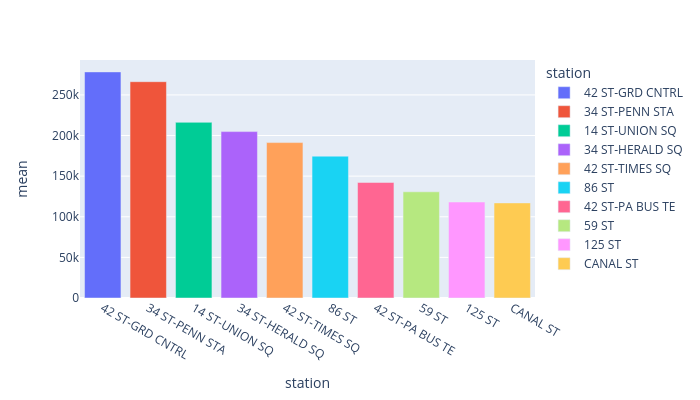

In [27]:
plot_mean_by_col('station', 'traffic', traffic_vs_station.reset_index())


Vemos que 42 ST-GRD CNTRL lidera o ranking das estações mais movimentadas em 2010, com um fluxo total de 50667496 passageiros, seguidos pelas estações 14 ST-UNION SQ e 86 ST, com 47950791 e 43778820 de tráfego, respectivamente. Dessa forma o objetivo desse case será a previsão do trafico em 7 dias para a estação `42 ST-GRD CNTRL`.

__Qual o dia da semana com maior fluxo?__

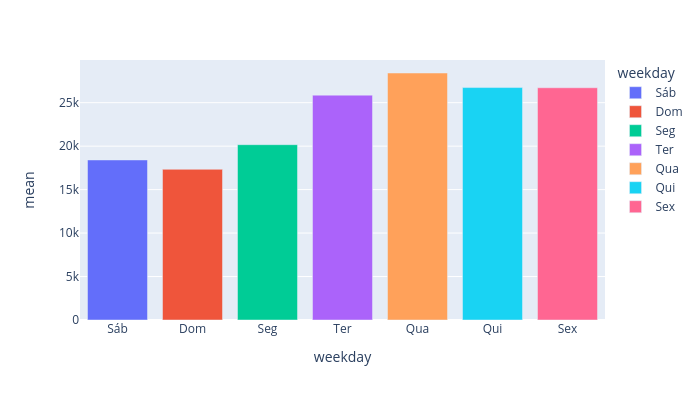

In [28]:
plot_mean_by_col('weekday', 'traffic', grouped_station)

De posse do gráfico acima podemos ver que o dia de maior fluxo é na `quarta feira`, vamos analisar agora em relação a estação  `42 ST-GRD CNTRL`

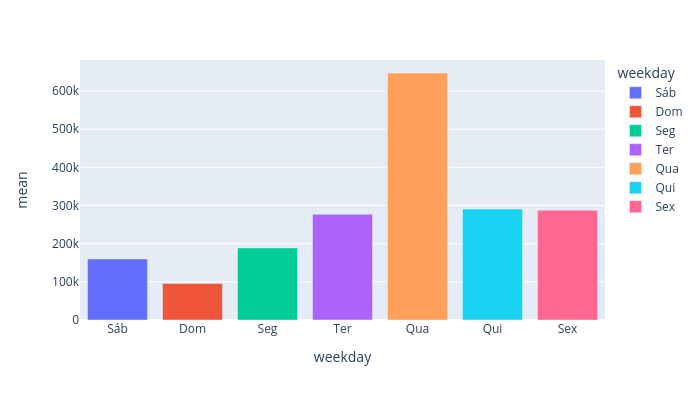

In [29]:
cntrl_station_df =  grouped_station[(grouped_station['station'] == '42 ST-GRD CNTRL')]
plot_mean_by_col('weekday', 'traffic', cntrl_station_df)

Como podemos o comportamento se repete, porém de maneira bem mais acentuada, agora os fluxo médio nas quartas feiras na estação `42 ST-GRD CNTRL` é mais que o dobro em relação as outras estações.

__O feriado influencia no tráfego?__

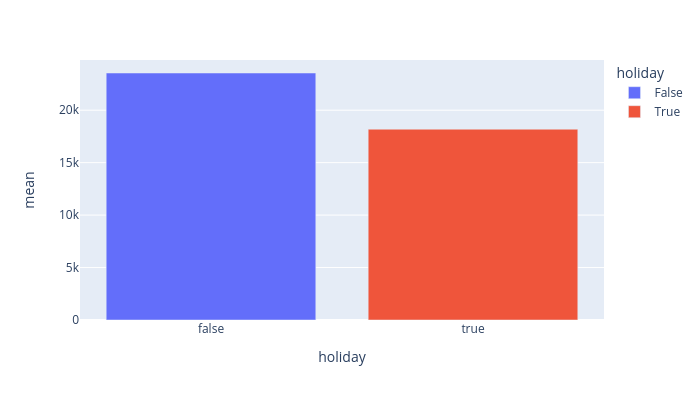

In [30]:
grouped_station['holiday'] = grouped_station['holiday'].map({1:True, 0:False})
plot_mean_by_col('holiday', 'traffic', grouped_station)

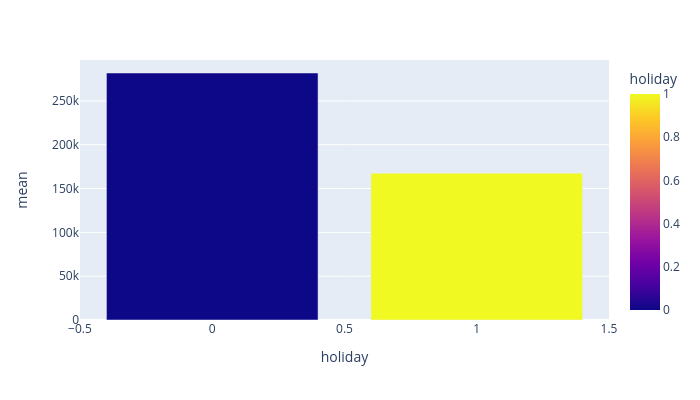

In [31]:
plot_mean_by_col('holiday', 'traffic', cntrl_station_df)

Novamente como vimos no caso do dia da semana, há uma influencia clara dos feriados em relação ao trafico, e esta influencia é mais acentuada na estação `42 ST-GRD CNTRL`

__Há relação dos meses em relação ao trafico?__

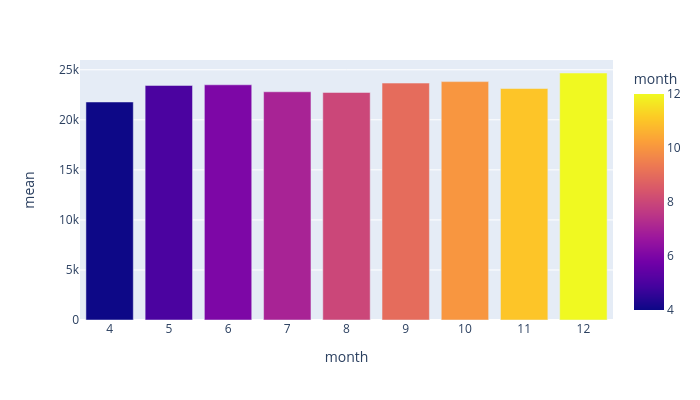

In [32]:
plot_mean_by_col('month', 'traffic', grouped_station, max_cols=12, linear_tick=True)

Como pode ser notado acima o valor médio do trafico em relação a todas as estações em relação aos meses é influenciado pelos meses, de forma provavelmente sazonal.

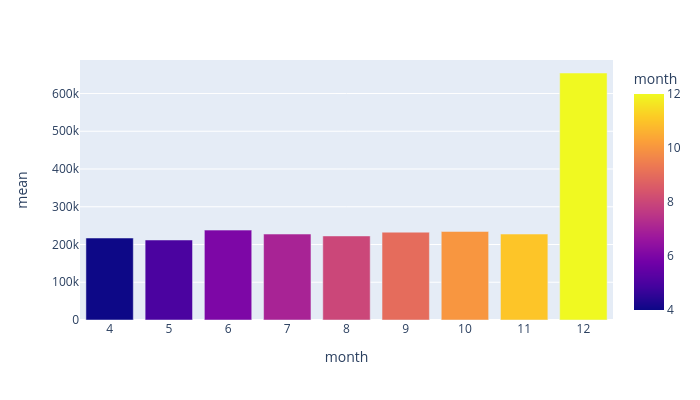

In [33]:
plot_mean_by_col('month', 'traffic', cntrl_station_df, max_cols=12, linear_tick=True)

De forma semelhante esse comportamento se repete na estação `42 ST-GRD CNTRL`, com exceção de dezembro, onde há um pico em relação a série temporal do trafico e os meses.

__Há relação dos dias mês em relação ao trafico?__

In [34]:
grouped_station

,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic
0,2010-04-17,Sáb,34 ST-PENN STA,False,4,17,45471.0,51391.0,96862.0
1,2010-04-17,Sáb,14 ST-UNION SQ,False,4,17,38958.0,56433.0,95391.0
2,2010-04-17,Sáb,34 ST-HERALD SQ,False,4,17,34304.0,41653.0,75957.0
3,2010-04-17,Sáb,86 ST,False,4,17,36939.0,38434.0,75373.0
4,2010-04-17,Sáb,CANAL ST,False,4,17,28036.0,34817.0,62853.0
...,...,...,...,...,...,...,...,...,...
98025,2010-12-31,Sex,BEACH 98 ST,True,12,31,297.0,498.0,795.0
98026,2010-12-31,Sex,AQUEDUCT TRACK,True,12,31,449.0,40.0,489.0
98027,2010-12-31,Sex,PATH WTC 2,True,12,31,346.0,0.0,346.0
98028,2010-12-31,Sex,BEACH 105 ST,True,12,31,104.0,211.0,315.0


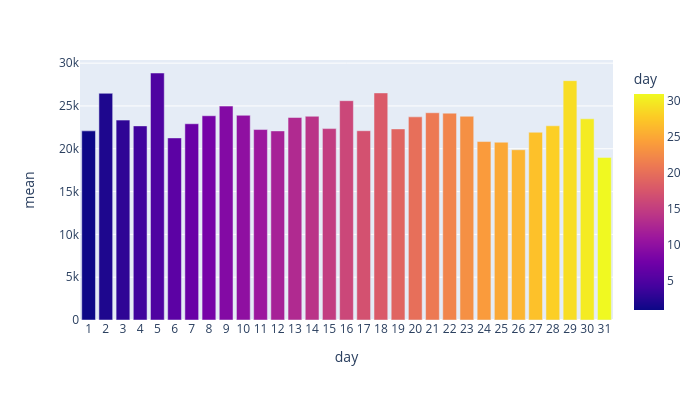

In [35]:
plot_mean_by_col('day', 'traffic', grouped_station.groupby(['day'])['traffic'].mean().reset_index(), max_cols=31, linear_tick=True)

Realizando essa análise agrupando por dias do mês podemos notar um comportamento sazonal estável, para verificar isso iremos analisar a série temporal do trafico médio de todas as estações a cada dia e sua autocorrelação. Além do comportamento sazonal é possível notar picos, provavelmente dias especificos nos quais há alguma data comemorativa ou algum acontecimento histórico.

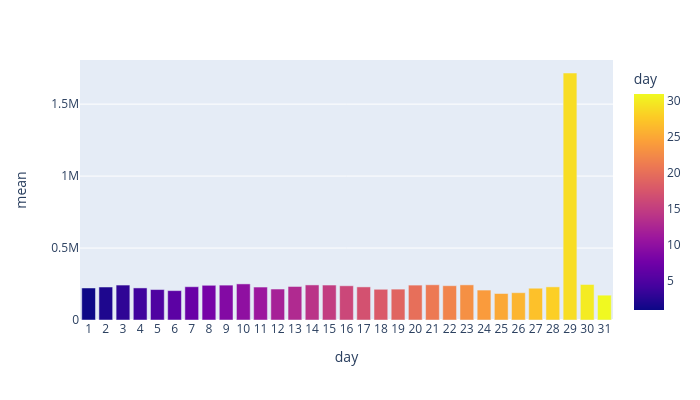

In [36]:
plot_mean_by_col('day', 'traffic', cntrl_station_df.groupby(['day'])['traffic'].mean().reset_index(), max_cols=31, linear_tick=True)

Olhando o comportamento da estação `42 ST-GRD CNTRL` percebemos que segue o mesmo comportamento sazonal presente na série temporal de dias do mês visto no gráfico do trafico médio de todas as estações, porém há um grande pico no dia `29`, o qual deve ser responsável também pelo pico de trafico no mês de dezembro.

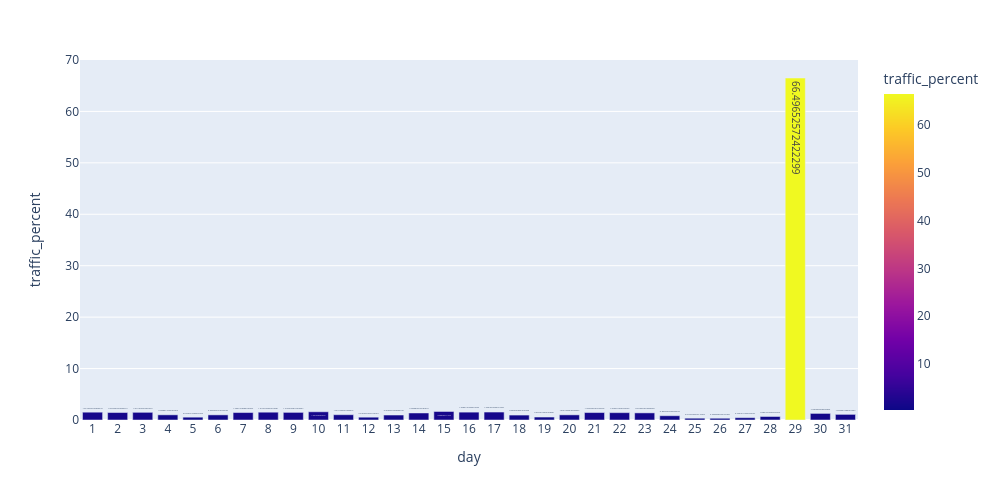

In [37]:
cntr_december_traffic = cntrl_station_df[(cntrl_station_df['month'] == 12)]
cntr_december_traffic['traffic_percent'] = cntr_december_traffic['traffic']/cntr_december_traffic['traffic'].sum()*100
fig = px.bar(cntr_december_traffic, x='day', y='traffic_percent', color='traffic_percent', 
                    barmode='group', text='traffic_percent')
fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 1,
            dtick = 1
        ),
        width=1000,
        height=500,
        )
fig.show('png')

In [38]:
cntrl_station_df.loc[cntrl_station_df['traffic'].idxmax()]

time             2010-12-29 00:00:00
weekday                          Qua
station              42 ST-GRD CNTRL
holiday                            0
month                             12
day                               29
entries_shift              6430878.0
exits_shift                7057907.0
traffic                   13488785.0
Name: 96890, dtype: object

Como podemos ver o dia 29 de dezembro apresentou um tráfico estrondoso nesse dia, reponsável por `66.4%` de todo tráfico no mês inteiro, e o maior valor de trafico em toda a base de dados para a estação `42 ST-GRD CNTRL`. Dessa forma, em nossa análise, afim de construir uma metodologia para a previsão de uma semana de tráfico diário da estação `42 ST-GRD CNTRL` vamos evitar essa data em especifico, definindo a data maxima de teste como o dia 28 de dezembro de 2010.

### 5.1 Análise da série temporal <a name=ti_ana></a>
Nessa parte iremos analisar a série temporal e determinar as influencias sazonais de maneira mais precisa além de também determinar a estacionaridade da série temporal de todas as estações e da estação selecionada para o problema de forecasting proposto nesse case.

In [39]:
def plot_series_and_peaks(target, time_col, df, title, peak_legend=None, peak_dist=7):
    fig = go.Figure(data=go.Scatter(y=df[target], x=df[time_col]))

    if peak_legend:
        all_peaks_indices = np.array([])
        indices = find_peaks(df[target].to_numpy(), distance=peak_dist,)[0]

        for idx in indices:
            xref = 'x'
            yref = 'y'
            fig.add_annotation(
                    x=df[time_col].iloc[idx],
                    y=df[target].iloc[idx],
                    xref=xref,
                    yref=yref,
                    text=f"{df[peak_legend].iloc[idx]}",
                    showarrow=True,
                    font=dict(
                        size=12,
                        ),
                    align="center",
                    arrowhead=2,
                    arrowsize=1,
                    arrowwidth=2,
                    arrowcolor="Red",
                    ax=-30,
                    ay=-30,
                    bordercolor="Black",
                    borderwidth=2,
                    borderpad=4,
                    bgcolor="#ff7f0e",
                    opacity=0.8
                    )

    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        font=dict(
        family="Times new Roman",
        size=18),
        template='seaborn',
        title=f'{title}',

    )
    fig.show('png')

__Sazonalidade__

In [55]:
# Selecionando parte da série da estação `42 ST-GRD CNTRL`, antes do pico de 29 de dezembro
cntrl_station_df = cntrl_station_df.reset_index()
cntrl_station_df = cntrl_station_df.iloc[:cntrl_station_df['traffic'].idxmax()]

# Calculando a autocorrelação
cntrl_station_df['auto_corr'] = statsmodels.tsa.stattools.acf(cntrl_station_df['traffic'].values, nlags = len(cntrl_station_df), fft=False)

In [57]:
cntrl_station_df.tail(10)

,index,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic,auto_corr,mean,cov,s_moment
246,93087,2010-12-19,Dom,42 ST-GRD CNTRL,0,12,19,59504.0,57297.0,116801.0,0.031533,252067.882353,0.0,70522.279094
247,93465,2010-12-20,Seg,42 ST-GRD CNTRL,0,12,20,88235.0,114648.0,202883.0,0.000614,241583.647059,0.0,76362.203204
248,93845,2010-12-21,Ter,42 ST-GRD CNTRL,0,12,21,150352.0,143646.0,293998.0,-0.025135,235724.470588,0.0,75277.850919
249,94227,2010-12-22,Qua,42 ST-GRD CNTRL,0,12,22,148594.0,141320.0,289914.0,-0.029424,241039.705882,0.0,76011.175542
250,94608,2010-12-23,Qui,42 ST-GRD CNTRL,0,12,23,146655.0,133656.0,280311.0,-0.010188,251562.176471,0.0,69377.607922
251,94990,2010-12-24,Sex,42 ST-GRD CNTRL,1,12,24,89560.0,78928.0,168488.0,0.014966,256180.705882,0.0,68518.993019
252,95375,2010-12-25,Sáb,42 ST-GRD CNTRL,0,12,25,35349.0,35086.0,70435.0,0.028926,248786.117647,0.0,70763.807654
253,95753,2010-12-26,Dom,42 ST-GRD CNTRL,0,12,26,37979.0,30962.0,68941.0,0.029310,234832.764706,0.0,80499.562783
254,96134,2010-12-27,Seg,42 ST-GRD CNTRL,0,12,27,43168.0,48065.0,91233.0,0.021448,221239.470588,0.0,87545.491589
255,96511,2010-12-28,Ter,42 ST-GRD CNTRL,0,12,28,64967.0,73463.0,138430.0,0.009073,207560.176471,0.0,88615.974961


In [58]:
# Agrupando o trafico de todas as estações por data e calculando a autocorrelação
all_station_mean_traffic = grouped_station.groupby(['time','month','weekday','day'])['traffic'].mean().reset_index()
all_station_mean_traffic['auto_corr'] = statsmodels.tsa.stattools.acf(all_station_mean_traffic['traffic'].values, nlags = len(all_station_mean_traffic), fft=False)

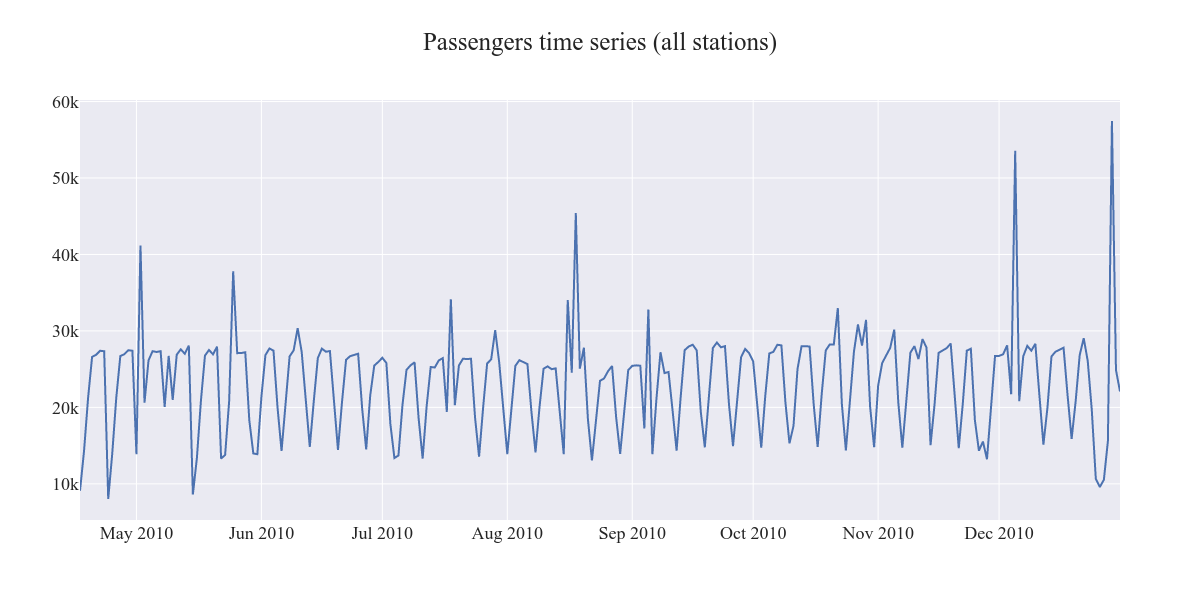

In [59]:
plot_series_and_peaks('traffic', 'time', all_station_mean_traffic, 'Passengers time series (all stations)', peak_dist=7)

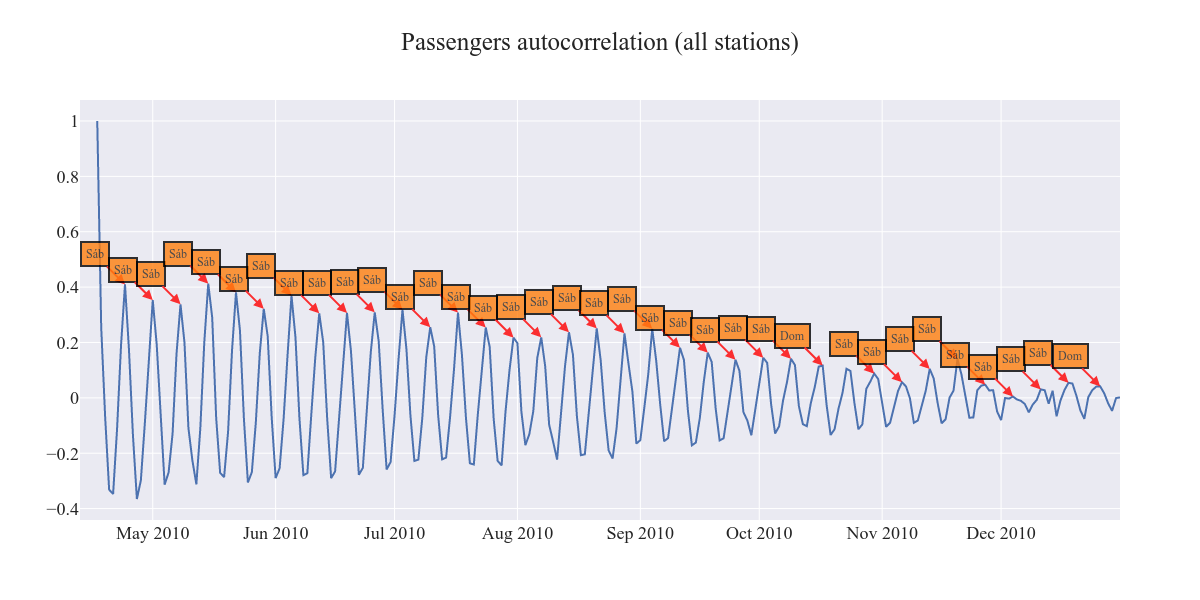

In [60]:
plot_series_and_peaks('auto_corr', 'time', all_station_mean_traffic, 'Passengers autocorrelation (all stations)', peak_legend='weekday', peak_dist=7)

Como podemos notar pelo comportamento da própria série temporal, temos um comportamento recorrente semanalmente. Essa hipótese é confirmada ao se olhar a autocorrelação dessa série, onde os picos se repetem todos aos finais de semana. Dessa forma, por mais que haja influencia dos meses, o comportamento sazonal dominante dessa série temporal é da ordem de semana.

Agora iremos verificar se o mesmo acontece quando se olhamos para a estação  `42 ST-GRD CNTRL`

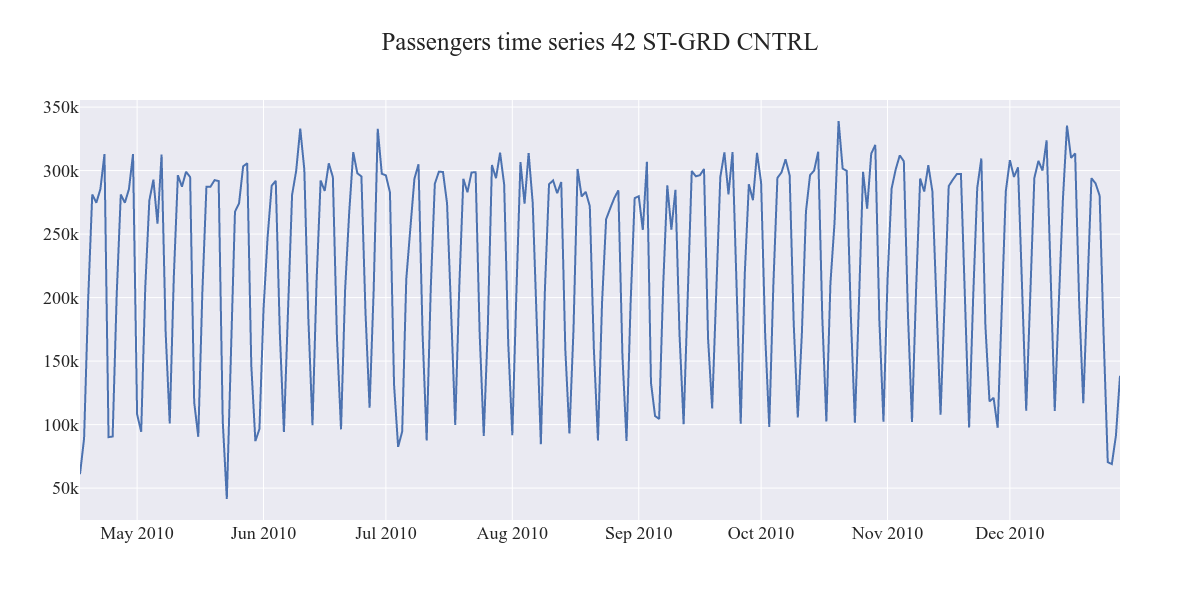

In [61]:
plot_series_and_peaks('traffic', 'time', cntrl_station_df, 'Passengers time series 42 ST-GRD CNTRL', peak_dist=7)

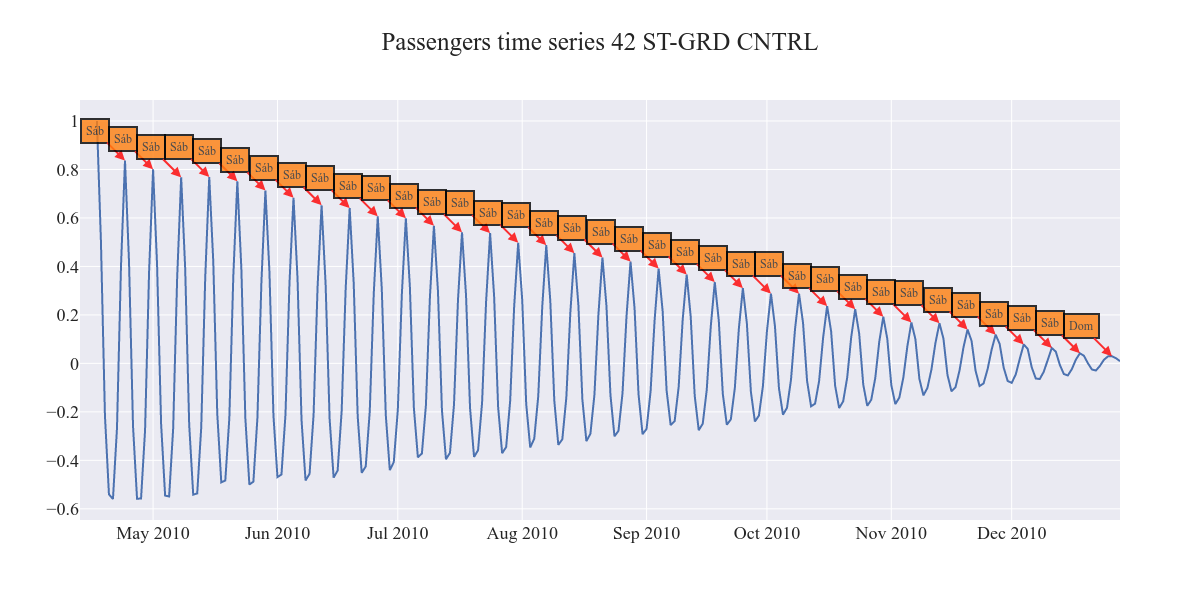

In [62]:
plot_series_and_peaks('auto_corr', 'time', cntrl_station_df, 'Passengers time series 42 ST-GRD CNTRL', peak_legend='weekday', peak_dist=7)

Como podemos ver o mesmo comportamento sazonal observado na série do trafico agregado de todas as estações continua, de maneira acentuada, na estação `42 ST-GRD CNTRL`. Dessa forma podemos afirmar que o trafico dessa estação tem o comportamento sazonal na ordem de semana.

### 5.2 Teste de estacionaridade no sentido amplo <a name=test></a>

Uma das análises mais importantes de dados de séries temporais é detectar se a série em questão é estacionária em sentido amplo ou não estacionária. Estacionaridade em sentido amplo de uma série temporal é uma característica que assegura que a série temporal não apresenta uma tendencia forte de descida ou subida e que esta série não apresenta sazonalidade. Utilizando-se dos dados de autocorrelação ja é um forte indicativo que a série temporal apresenta sazonalidade anual e somente utilizando essa informação é possível afirmar que a nossa série é não estacionária no sentido amplo. Porém podemos confirmar essa hipótese utilizando o teste de estacionaridade.

Muitos autores de artigos que utilizam machine learning para séries temporais defendem que usar esse tipo de modelo de aprendizado de máquina não exige necessariamente que os dados já estejam estacionários. No entanto, é importante saber se os dados são estacionários mesmo que o modelo selecionado seja baseado em ML, pois se o modelo não convergir bem isso pode ser uma causa e conhecer as propriedades da série também é muito valioso.

[1] Defina uma série temporal estacionária fraca se a função média $ E[x(t)] $ for independente de $ t $, se a função de autocoraviação $Cov (x(t+h), x(t))$ for independente de $ t $ para cada $h$ e se $E[x^2[n]]$ for finito para cada $n$.

Para realizar o teste de estacionaridade, a função média e a função de autocovariação foram aplicadas sobre janelas rolantes, desde seus dados amostrados. Assim, o tamanho da janela tem impacto sobre as interpretações das funções, a janela representa o intervalo em que a hipótese estacionária é testada.

Além desta definição, a biblioteca $ statsmodels $ possui o teste de raiz unitária Augmented Dickey-Fuller. O teste Augmented Dickey-Fuller pode ser usado para testar uma raiz unitária em um processo univariado na presença de correlação sazonal.

Referências
[1] Brockwell, Peter J. e Richard A. Davis. Introdução às séries temporais e previsão. Springer, 2016.

In [82]:
def stationary_test(entry, window_size, tgt_col='traffic'):
    entry['mean'] = entry[tgt_col].rolling(window_size).mean()
    entry['cov'] = entry[tgt_col].rolling(window_size).cov()
    entry['s_moment']= entry[tgt_col].rolling(window_size).apply(lambda x: moment(x,moment=2))

    result = adfuller(entry[tgt_col].values)
    print("ADF Statistic: %f" % result[0])
    print("p-value: {0}".format(result[1]))
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))
    # if the p-value < 0.05  and the adf statistic is less than
    # critical values the series is stationary or is time independent

    return entry


ADF Statistic: -3.596965
p-value: 0.005819316548343936
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


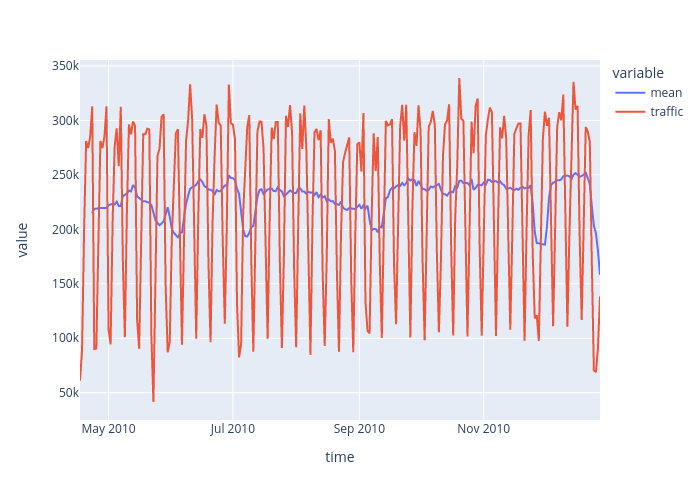

In [84]:
# Weak stationary test
cntrl_station_df = stationary_test(cntrl_station_df, 7)

# Removendo colunas não mais necessárias
del cntrl_station_df['index']
del cntrl_station_df['auto_corr']

fig = px.line(cntrl_station_df, x='time', y=['mean', 'traffic'])
fig.show('png')

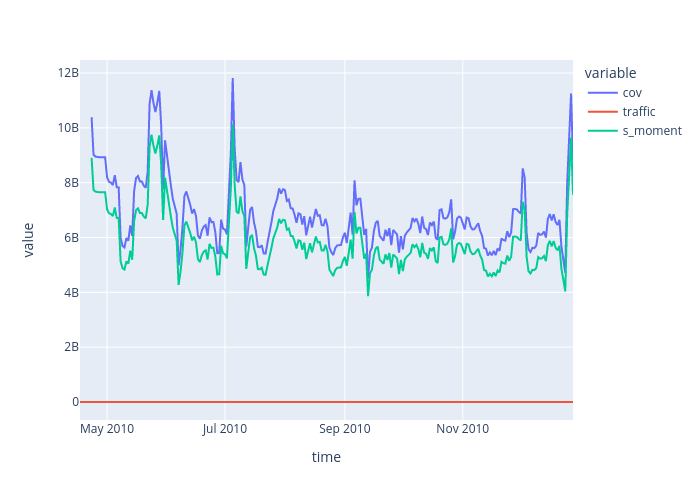

In [85]:

fig = px.line(cntrl_station_df, x='time', y=['cov', 'traffic', 's_moment'])
fig.show('png')

__Analisando os resultados do teste__

A hipótese de teste da função média falhou, isto pode ser observado verificando a função seguindo a tendência e a sazonalidade das séries de trafico. A função de covariação não apresenta um comportamento de crescimento explosivo assim passando dessa condição. A função de segundo momento não mostra uma tendência para o infinito com qualquer $n$, passando dessa forma esta condição.

Analisando os gráficos de funções é correto inferir que esta série de trafico não é estacionária em relação a definição formal de um processo estocástico. Porém, como estamos analisando uma série temporal, a qual seria uma realização de um processo estocástico, é melhor avaliar a estacionaridade utilizando-se do teste de Dickey-Fuller.

Além dos testes de estatística em janela, o teste de Dickey-Fuller implementado pode ser feito para verificar se a série de trafico é estacionária ou não. Este teste verifica se a série tem uma raiz unitária e, ao fazê-lo, pode fazer a suposição de quanto a série é definida pela sua tendência.

Existem 2 Hipóteses:

Hipótese Nula (H0): Se não for rejeitada, sugere que a série tem uma raiz unitária, o que significa que é não-estacionária. Tem alguma estrutura dependente do tempo.

Hipótese alternativa (H1): A hipótese nula é rejeitada; sugere que a série não tem uma raiz unitária, o que significa que é estacionária. Não tem uma estrutura dependente do tempo.

Interpretamos este resultado utilizando o valor p do teste. Um valor p abaixo de um limiar (como 5% ou 1%) sugere que rejeitamos a hipótese nula (estacionária), caso contrário, um valor p acima do limiar sugere que não rejeitamos a hipótese nula (não estacionária).

p-valor > 0,05: Não rejeitar a hipótese nula (H0), os dados têm uma raiz unitária e são não-estacionários.
p-valor <= 0,05: Rejeitar a hipótese nula (H0), os dados não têm uma raiz unitária e são estacionários.

Uma vez que o valor p do valor do teste aplicado à série é inferior a 0,05, a hipótese nula é rejeitada, assim a série é estacionária analisando-se pelo teste de Dickey-Fuller. De posse dessa análise, dos testes de janela, e da autocorrelação dessa série podemos chegar na conclusão que essa série é um caso especial de estacionaridade, quando há a presença de sazonalidade porém esta presença é estável. Dessa forma, a nossa série de tráfico de passageiros se assemelha com um sinal senoidal, com periodo definido e variação estável.

### 5.3 Análise de covariantes <a name=cov></a>

Agora vamos analisar a correlação do fluxo passageiros com as outras variáveis para verificar se estas serão boas features para os nossos modelos, para isso antes vamos realizar a criação de novas features e o tratamento de features string para booleanas.

In [132]:
# Realizando tratamento de fill para as features de mean cov e s_moment
cntrl_station_df = cntrl_station_df.ffill().bfill()
cntrl_station_df

,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic,mean,cov,s_moment
0,2010-04-17,Sáb,42 ST-GRD CNTRL,0,4,17,29743.0,31275.0,61018.0,214672.714286,1.039046e+10,8.906106e+09
1,2010-04-18,Dom,42 ST-GRD CNTRL,0,4,18,45878.0,43154.0,89032.0,214672.714286,1.039046e+10,8.906106e+09
2,2010-04-19,Seg,42 ST-GRD CNTRL,0,4,19,87516.0,110942.0,198458.0,214672.714286,1.039046e+10,8.906106e+09
3,2010-04-20,Ter,42 ST-GRD CNTRL,0,4,20,142676.0,138496.0,281172.0,214672.714286,1.039046e+10,8.906106e+09
4,2010-04-21,Qua,42 ST-GRD CNTRL,0,4,21,139905.0,134758.0,274663.0,214672.714286,1.039046e+10,8.906106e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
251,2010-12-24,Sex,42 ST-GRD CNTRL,1,12,24,89560.0,78928.0,168488.0,220989.571429,4.706561e+09,4.034195e+09
252,2010-12-25,Sáb,42 ST-GRD CNTRL,0,12,25,35349.0,35086.0,70435.0,203261.428571,8.001005e+09,6.858004e+09
253,2010-12-26,Dom,42 ST-GRD CNTRL,0,12,26,37979.0,30962.0,68941.0,196424.285714,9.707563e+09,8.320768e+09
254,2010-12-27,Seg,42 ST-GRD CNTRL,0,12,27,43168.0,48065.0,91233.0,180474.285714,1.124801e+10,9.641150e+09


In [135]:
# Mapeando valores dos dias da semana para valores numéricos
week_map = {}
for i, day in enumerate(cntrl_station_df['weekday'].unique()):
    week_map[day] = i
cntrl_station_df['weekday'] = cntrl_station_df['weekday'].map(week_map)
cntrl_station_df.head(7)

,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic,mean,cov,s_moment
0,2010-04-17,0,42 ST-GRD CNTRL,0,4,17,29743.0,31275.0,61018.0,214672.714286,1.039046e+10,8.906106e+09
1,2010-04-18,1,42 ST-GRD CNTRL,0,4,18,45878.0,43154.0,89032.0,214672.714286,1.039046e+10,8.906106e+09
2,2010-04-19,2,42 ST-GRD CNTRL,0,4,19,87516.0,110942.0,198458.0,214672.714286,1.039046e+10,8.906106e+09
3,2010-04-20,3,42 ST-GRD CNTRL,0,4,20,142676.0,138496.0,281172.0,214672.714286,1.039046e+10,8.906106e+09
4,2010-04-21,4,42 ST-GRD CNTRL,0,4,21,139905.0,134758.0,274663.0,214672.714286,1.039046e+10,8.906106e+09
5,2010-04-22,5,42 ST-GRD CNTRL,0,4,22,149842.0,135566.0,285408.0,214672.714286,1.039046e+10,8.906106e+09
6,2010-04-23,6,42 ST-GRD CNTRL,0,4,23,157998.0,154960.0,312958.0,214672.714286,1.039046e+10,8.906106e+09


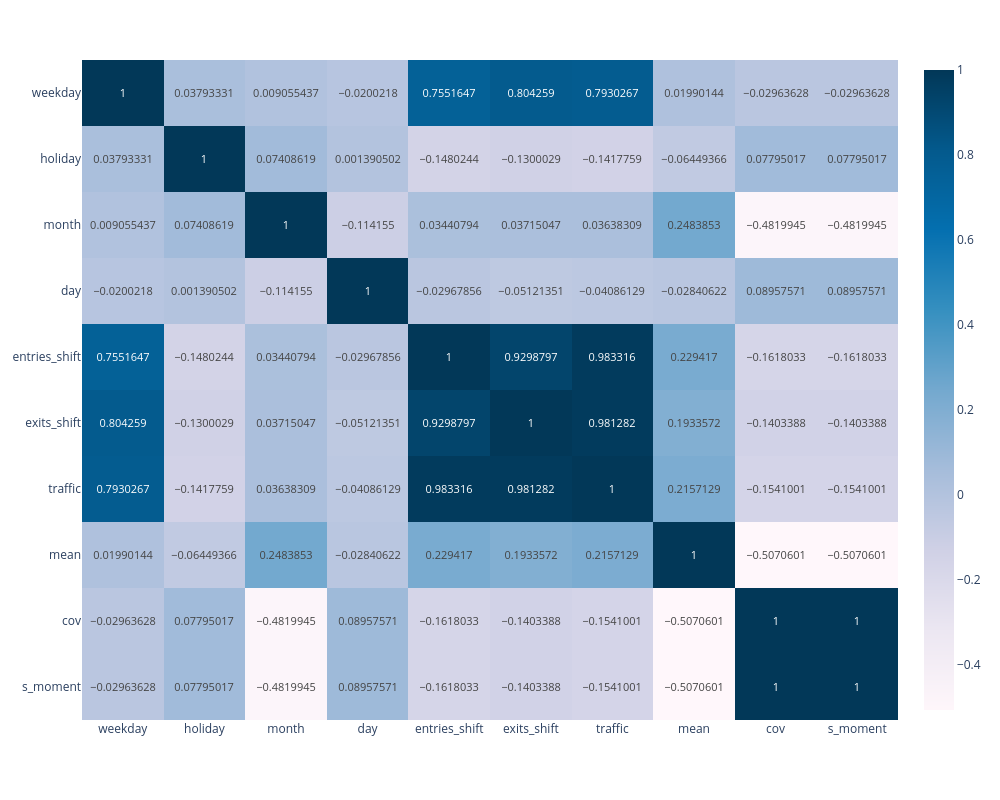

In [136]:
fig = px.imshow(cntrl_station_df[cntrl_station_df.columns[1:]].corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
fig.show('png')

 A partir do gráfico correlação cruzada é possível concluir que as variáveis de 'traffic', 'entries_shift', 'exit_shift' e 'weekday' tem uma alta correlação entre si, como era de se esperar.

__Relação da coluna do trafico de passageiros de amostras de 7 dias anteriores com as outras colunas de valores numéricos__

Esse tipo de análise é importante para visualizar se esses dados serão de alguma valia para inserir em modelos que aceitam entradas exógenas como o ARIMAX, e visto que não teremos acesso a essas covariantes numéricas no futuro teremos que associar o valor de passageiros entrantes em relação aos 6 meses anteriores dos valores numéricos, que estarão a nossa disposição.

In [165]:
def generate_lag_set(entry_set, numeric_cols, lag_order=7):
    lag_set = entry_set[::]
    for col in numeric_cols:
        lag_set[f'{col}_lag_{lag_order}'] = lag_set[col].shift(lag_order)
    lag_set = lag_set.ffill().bfill()
    return lag_set

In [166]:
numeric_cols = ['traffic', 'mean']
cntrl_lag_df = generate_lag_set(cntrl_station_df, numeric_cols)

In [167]:
cntrl_lag_df.tail()

,time,weekday,station,holiday,month,day,entries_shift,exits_shift,traffic,mean,cov,s_moment,traffic_lag_7,mean_lag_7
251,2010-12-24,6,42 ST-GRD CNTRL,1,12,24,89560.0,78928.0,168488.0,220989.571429,4.706561e+09,4.034195e+09,313491.0,250141.000000
252,2010-12-25,0,42 ST-GRD CNTRL,0,12,25,35349.0,35086.0,70435.0,203261.428571,8.001005e+09,6.858004e+09,194532.0,248165.714286
253,2010-12-26,1,42 ST-GRD CNTRL,0,12,26,37979.0,30962.0,68941.0,196424.285714,9.707563e+09,8.320768e+09,116801.0,249042.428571
254,2010-12-27,2,42 ST-GRD CNTRL,0,12,27,43168.0,48065.0,91233.0,180474.285714,1.124801e+10,9.641150e+09,202883.0,250043.285714
255,2010-12-28,3,42 ST-GRD CNTRL,0,12,28,64967.0,73463.0,138430.0,158250.285714,8.818466e+09,7.558685e+09,293998.0,252458.857143


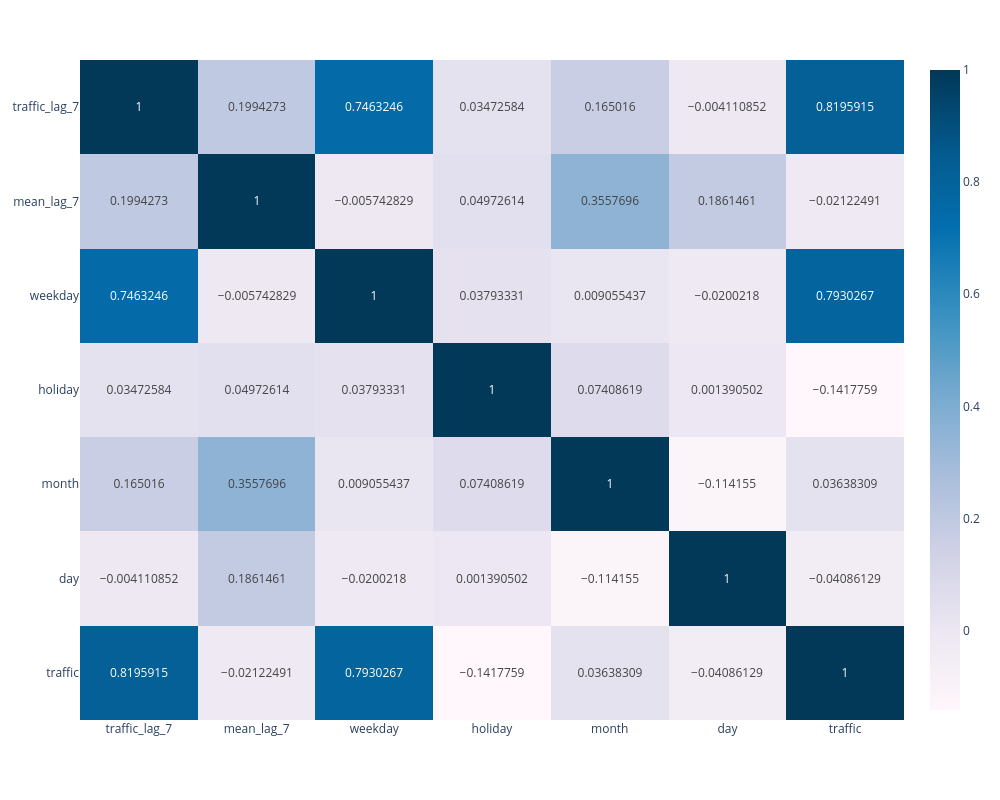

In [168]:
fig = px.imshow(cntrl_lag_df[['traffic_lag_7','mean_lag_7','weekday','holiday','month','day','traffic']].corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
fig.show('png')

Ao olhar o grafico acima é possivel notar uma correlação dos dados atrasados em 7 dias do trafico com a propria coluna do trafico. Ou seja para algoritimos como a regressão linear essa coluna nova de atrasos vai ser de alguma valia para traçar o comportamento de 7 dias adiante no tempo do trafico baseado no seu passado. Além disso ainda se faz presente a correlação alta com o dia da semana.

## 6. Modelagem <a name=model></a>
Para modelar a predição de 6 meses a frente da série temporal de trafico de passageiros vamos utilizar quatro modelos, sendo estes:

- `ARIMA`: Modelo amplamente utilizado na literatura para vários casos, altamente performático e bastante utilizado no mercado.
- `Light GBM`: Modelo baseado em árvores de decisão e gradient boosting, é dito estar no estado da arte na modelagem de dados tabulares para vários tipos de tarefas e altamente performático.

- `Prophet`: Modelo de previsão de séries temporais desenvolvido pelo Facebook, amplamente utilizado e performático.
- `Regressão linear`: Modelo baseado em regressão linear de covariantes em relação a série temporal desejada.

__Definindo os conjuntos de treino validação e teste__

In [187]:
# Definindo conjuntos de treino validação e teste
initial_month = cntrl_lag_df.iloc[0]['month']
val_months = list(cntrl_lag_df['month'].unique())[-6:-1]
train_months = [list(range(initial_month, i)) for i in val_months]
pd.DataFrame({ 'train_months': train_months, 'val_months': val_months})

,train_months,val_months
0,"[4, 5, 6]",7
1,"[4, 5, 6, 7]",8
2,"[4, 5, 6, 7, 8]",9
3,"[4, 5, 6, 7, 8, 9]",10
4,"[4, 5, 6, 7, 8, 9, 10]",11


In [232]:
test_sz = 7
x_cols  = ['weekday', 'month', 'holiday', 'traffic_lag_7', 'mean_lag_7', 'traffic']
y_cols  = ['traffic','time']
exog_cols = x_cols[:-1]

data_train = []
data_val = []
for val_i in val_months:
    data_train.append(cntrl_lag_df.loc[cntrl_lag_df['month'] < val_i])
    data_val.append(cntrl_lag_df.loc[cntrl_lag_df['month'] == val_i].iloc[:test_sz])

In [233]:
# Dados de teste
last_train_set, last_test_set = cntrl_lag_df.iloc[:-test_sz], cntrl_lag_df.iloc[-test_sz:]

### 6.1 ARIMA <a name=arima></a>

#### ARIMA

O modelo ARIMA tem 3 componentes, o componente autoregressivo (AR), o componente de médias móveis (MA) e o componente Integrativo (I).

Primeiramente vamos modelar o ARIMA utilizando somente a série endogena (tráfico de passageiros) e depois vamos utilizar as outras colunas numéricas e verificar qual foi a melhor abordagem.

In [234]:
def plot_forecast(series_train, series_test, forecast, y_col='traffic', forecast_int=None):

    mae = mean_absolute_error(series_test[y_col], forecast)
    mape = mean_absolute_percentage_error(series_test[y_col], forecast)

    fig = make_subplots(rows=2, cols=1,
                    subplot_titles=[f'All time series', 'Prediction and ground truth'],
                    x_title='Input time steps',
                    y_title='Output time steps')
    fig.add_trace(go.Scatter(x=series_train['time'], y=series_train[y_col], name='Train data'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['time'], y=series_test[y_col],  name='True values'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['time'], y=forecast,  name='forecast'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['time'], y=series_test[y_col],  name='True values'), row=2, col=1)
    fig.add_trace(go.Scatter(x=series_test['time'], y=forecast,  name='forecast'), row=2, col=1)

    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        font=dict(
        family="Times new Roman",
        size=18),
        template='seaborn',
        title=f"Traffic forecast  | MAE: {mae:.2f} | MAPE: {mape:.3f}",
    )
    fig.show('png')

In [315]:
def arima_fit_pred(dataset_train, dataset_test, exog=None, exog_cols=None, plot=False, test_sz=7):
    forecaster = AutoARIMA(sp=7, suppress_warnings=True)
    dataset_train.index = dataset_train.index.astype(int)
    if exog:
        X=dataset_train[exog_cols]
    else:
        X=None
    forecaster.fit(dataset_train['traffic'], X=X)
    forecaster.summary()
    test_sz = len(dataset_test)
    fh = np.arange(test_sz) + 1

    if exog:
        X=dataset_test[exog_cols]

    forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05, X=X)
    if plot:
        plot_forecast(dataset_train, dataset_test, forecast)
    else:
        return forecast

In [251]:
def val_metric_df(train_func, dataset_train, dataset_val, model_name, exog_cols=None):
    metric_df = {'model': [], 'val_month': [], 'R2':[], 'MAE':[], 'MAPE': [], 'Exog': []}
    for train_set, val_set in zip(dataset_train, dataset_val):
        if model_name == 'Prophet':
            pred = train_func(train_set, val_set)
        else:
            pred = train_func(train_set,
                              val_set,
                              exog=True if exog_cols is not None else False,
                              exog_cols=exog_cols)
        y_true = val_set['traffic']
        metric_df['model'].append(model_name)
        metric_df['val_month'].append(val_set.iloc[0]['month'])
        metric_df['MAE'].append(mean_absolute_error(y_true, pred))
        metric_df['MAPE'].append(mean_absolute_percentage_error(y_true, pred))
        metric_df['R2'].append(r2_score(y_true, pred))
        metric_df['Exog'].append(True if exog_cols is not None else False)

    return pd.DataFrame(metric_df)


__Validação OOT de ARIMA sem entradas exogenas__

In [228]:
val_metric_df(arima_fit_pred, data_train, data_val, 'ARIMA')

,model,val_month,R2,MAE,MAPE,Exog
0,ARIMA,7,0.331135,54391.267644,0.395588,False
1,ARIMA,8,0.952118,14055.777981,0.081676,False
2,ARIMA,9,0.624743,38037.878016,0.249443,False
3,ARIMA,10,0.914847,19111.224443,0.082527,False
4,ARIMA,11,0.960138,10310.570104,0.050435,False


__Validação OOT de ARIMA com entradas exogenas__

In [237]:
val_metric_df(arima_fit_pred, data_train, data_val, 'ARIMA', exog_cols=exog_cols)

,model,val_month,R2,MAE,MAPE,Exog
0,ARIMA,7,0.683279,40590.067233,0.261232,True
1,ARIMA,8,0.963917,13028.999543,0.055464,True
2,ARIMA,9,0.850375,26887.647753,0.150899,True
3,ARIMA,10,0.975696,10183.950287,0.045578,True
4,ARIMA,11,0.991637,5800.117685,0.024091,True


Olhando os resultados das duas tabelas percebemos que a combinação de entradas exogenas ajudou o modelo, portanto agora iremos testa-lo utilizando-as

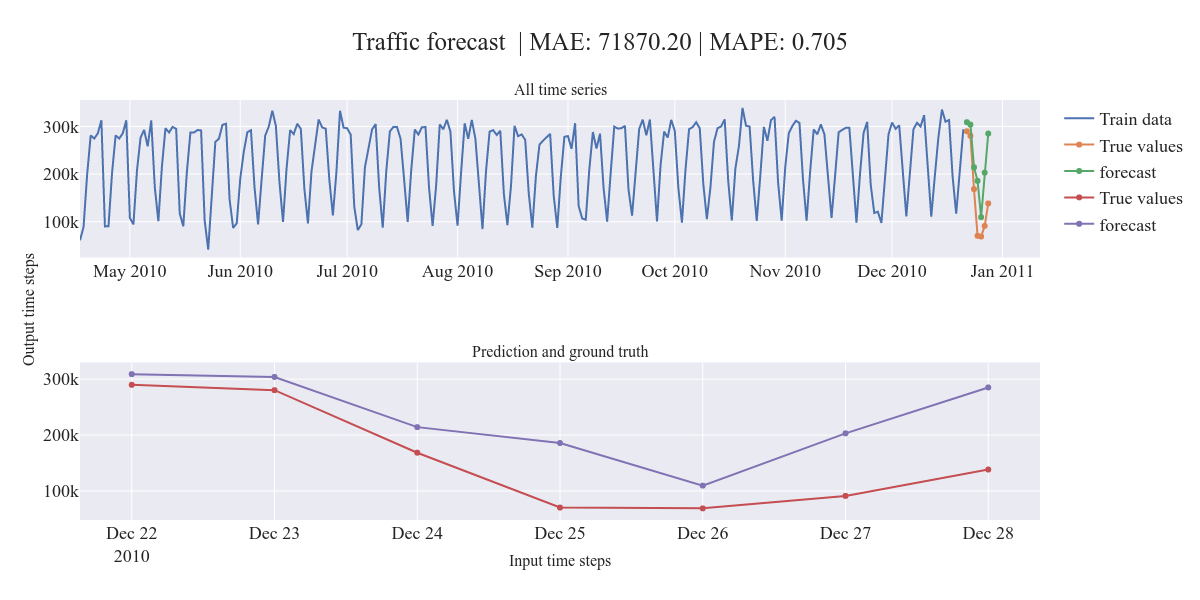

In [240]:
arima_fit_pred(last_train_set, last_test_set, exog=True, exog_cols=exog_cols, plot=True)

### 6.2 Light GBM <a name=lgbm></a>

Semelhante ao ARIMA vamos testar o modelo utilizando somente a série de passageiros entrantes e depois com as outras covariantes. Para isso vamos utilizar uma busca de parâmetros utilizando o método de grid search, e utilizando o `sktime` nós iremos remover os componentes de tendência e sazonalidade.

In [241]:
def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster

def grid_search_forecaster(train, test, forecaster, param_grid, exog=None, exog_cols=None, y_col='Passengers In'):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    if exog:
        X = train[exog_cols]
    else:
        X = None
    gscv.fit(train[y_col], X=X, fh=len(test))
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh=np.arange(len(test))+1
    if exog:
        X = test[exog_cols]
    else:
        X = None
    y_pred = gscv.predict(fh=fh, X=X)

    return gscv, y_pred


def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor(learning_rate=0.2, n_estimators=100)
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )

    return forecaster

def lgbm_fit_pred(train_set, test_set ,y_col='traffic',exog=None, exog_cols=None, plot=False):

    forecaster = create_forecaster_w_desesonalizer()
    param_grid = {"forecast__window_length": [6, 24, 36], 'forecast__estimator__learning_rate': [0.1,  0.16, 0.2 ]}

    gscv, forecast = grid_search_forecaster(train_set, test_set, forecaster,param_grid, exog=exog, exog_cols=exog_cols, y_col=y_col)
    if plot:
        plot_forecast(train_set, test_set, forecast)
    else:
        return forecast


__Validação OOT de Light GBM sem entradas exogenas__

In [242]:
val_metric_df(lgbm_fit_pred, data_train, data_val, 'LGBM')

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 6}
best params: {'forecast__estimator__learning_rate': 0.16, 'forecast__window_length': 24}
best params: {'forecast__estimator__learning_rate': 0.16, 'forecast__window_length': 24}
best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 36}
best params: {'forecast__estimator__learning_rate': 0.2, 'forecast__window_length': 36}


,model,val_month,R2,MAE,MAPE,Exog
0,LGBM,7,0.511148,51177.844837,0.407362,False
1,LGBM,8,0.881974,24603.018940,0.117792,False
2,LGBM,9,0.573399,40569.581649,0.259517,False
3,LGBM,10,0.928436,15832.618976,0.092655,False
4,LGBM,11,0.964592,12434.904426,0.057152,False


__Validação OOT de Light GBM com entradas exogenas__

In [243]:
val_metric_df(lgbm_fit_pred, data_train, data_val, 'LGBM', exog_cols=exog_cols)

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 6}
best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 6}
best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 24}
best params: {'forecast__estimator__learning_rate': 0.16, 'forecast__window_length': 6}
best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 6}


,model,val_month,R2,MAE,MAPE,Exog
0,LGBM,7,0.714451,36454.273066,0.298321,True
1,LGBM,8,0.849284,26569.236924,0.131308,True
2,LGBM,9,0.369790,46388.481787,0.300216,True
3,LGBM,10,0.979447,10087.007284,0.053668,True
4,LGBM,11,0.964189,12596.649232,0.058081,True


Olhando os resultados das duas tabelas percebemos que a combinação de entradas exogenas ajudou o modelo, portanto agora iremos testa-lo utilizando-as

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 24}


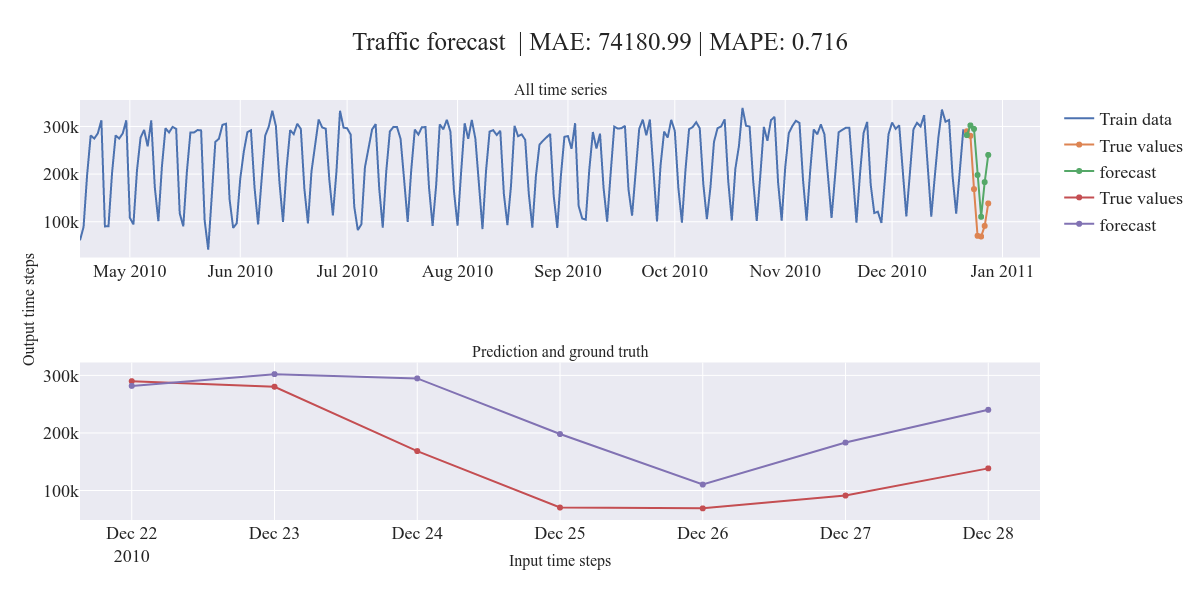

In [245]:
lgbm_fit_pred(last_train_set, last_test_set, exog=True, exog_cols=exog_cols, plot=True)

### 6.3 Prophet <a name=prop></a>
O prophet diferentemente dos modelos anteriores não possibilita a entrada de covariantes, dessa forma vamos testa-lo utilizando somente a série trafico de passageiros

In [267]:
def prophet_fit_pred(dataset_train, dataset_test, plot=False):
    al_train_pp = dataset_train[['time', 'traffic']]
    al_train_pp.head()

    # Prophet requires specific column names: ds and y
    al_train_pp.columns = ["ds", "y"]

    # turning on only yearly seasonality as this is monthly data.
    # As the seasonality effects varies across years, we need multiplicative seasonality mode
    m = Prophet(weekly_seasonality=True)
    m.add_country_holidays(country_name='US')
    m.fit(al_train_pp)

    future = m.make_future_dataframe(periods=test_sz, freq="D")
    forecast = m.predict(future)
    forecast = forecast.iloc[-test_sz:]
    forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"}, inplace=True)

    if plot:
        plot_forecast(
            dataset_train, dataset_test, forecast['yhat'])
    else:
        return forecast['yhat']

__Validação OOT de Prophet__

In [270]:
val_metric_df(prophet_fit_pred, data_train, data_val, 'Prophet')


Initial log joint probability = -83.9989
Iteration  1. Log joint probability =    58.5028. Improved by 142.502.
Iteration  2. Log joint probability =    59.3877. Improved by 0.884914.
Iteration  3. Log joint probability =    131.173. Improved by 71.7853.
Iteration  4. Log joint probability =    161.314. Improved by 30.1413.
Iteration  5. Log joint probability =     163.86. Improved by 2.54604.
Iteration  6. Log joint probability =    164.277. Improved by 0.416112.
Iteration  7. Log joint probability =    164.278. Improved by 0.00194845.
Iteration  8. Log joint probability =    164.316. Improved by 0.0380214.
Iteration  9. Log joint probability =    164.328. Improved by 0.0111073.
Iteration 10. Log joint probability =    164.343. Improved by 0.0153588.
Iteration 11. Log joint probability =    164.353. Improved by 0.0103108.
Iteration 12. Log joint probability =    164.362. Improved by 0.00902363.
Iteration 13. Log joint probability =    164.367. Improved by 0.00515653.
Iteration 14. Lo

,model,val_month,R2,MAE,MAPE,Exog
0,Prophet,7,0.480698,48105.942409,0.348296,False
1,Prophet,8,0.933986,16990.928222,0.078993,False
2,Prophet,9,0.622142,36543.618561,0.247246,False
3,Prophet,10,0.984930,8214.668017,0.033198,False
4,Prophet,11,0.986676,5836.861138,0.028365,False


Initial log joint probability = -15.5811
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        546.36   0.000658405       75.9347      0.7525      0.7525      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       548.692   0.000463233        99.919   4.131e-06       0.001      230  LS failed, Hessian reset 
     195       548.785   1.68899e-05       84.8797   1.685e-07       0.001      313  LS failed, Hessian reset 
     199       548.786   3.63722e-06        101.66      0.1779           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       548.787   6.40254e-09       91.2471      0.1496      0.1496      358   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


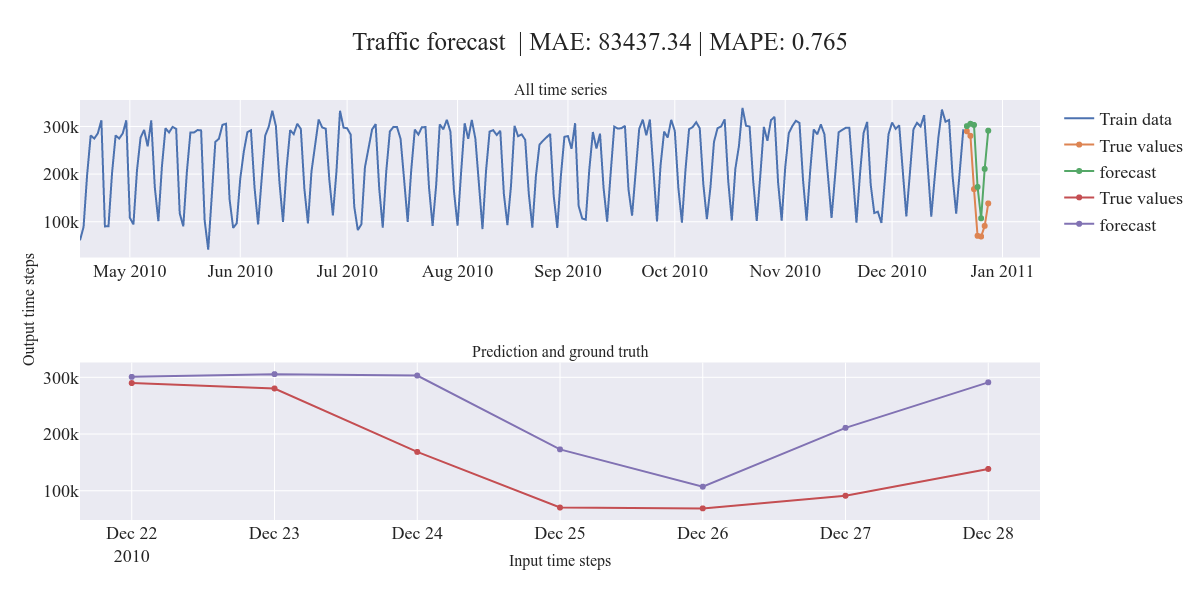

In [271]:
prophet_fit_pred(last_train_set, last_test_set, plot=True)

### 6.4 regressão linear simples <a name=linear></a>

In [276]:
def linear_fit_pred(dataset_train, dataset_test, exog=True ,exog_cols=exog_cols, plot=False):
    lr = LinearRegression()
    lr.fit(dataset_train[exog_cols], dataset_train['traffic'])
    y_pred_lr = pd.Series(lr.predict(X=dataset_test[exog_cols]),index=dataset_test.index)
    if plot:
        plot_forecast(
            dataset_train, dataset_test, y_pred_lr)
    else:
        return y_pred_lr

In [277]:
val_metric_df(linear_fit_pred, data_train, data_val, 'lr', exog_cols=exog_cols)

,model,val_month,R2,MAE,MAPE,Exog
0,lr,7,0.852078,25279.879422,0.177911,True
1,lr,8,0.799245,29546.152988,0.155354,True
2,lr,9,0.920932,17259.107361,0.094485,True
3,lr,10,0.857065,25951.883266,0.118531,True
4,lr,11,0.883276,23436.271700,0.115884,True


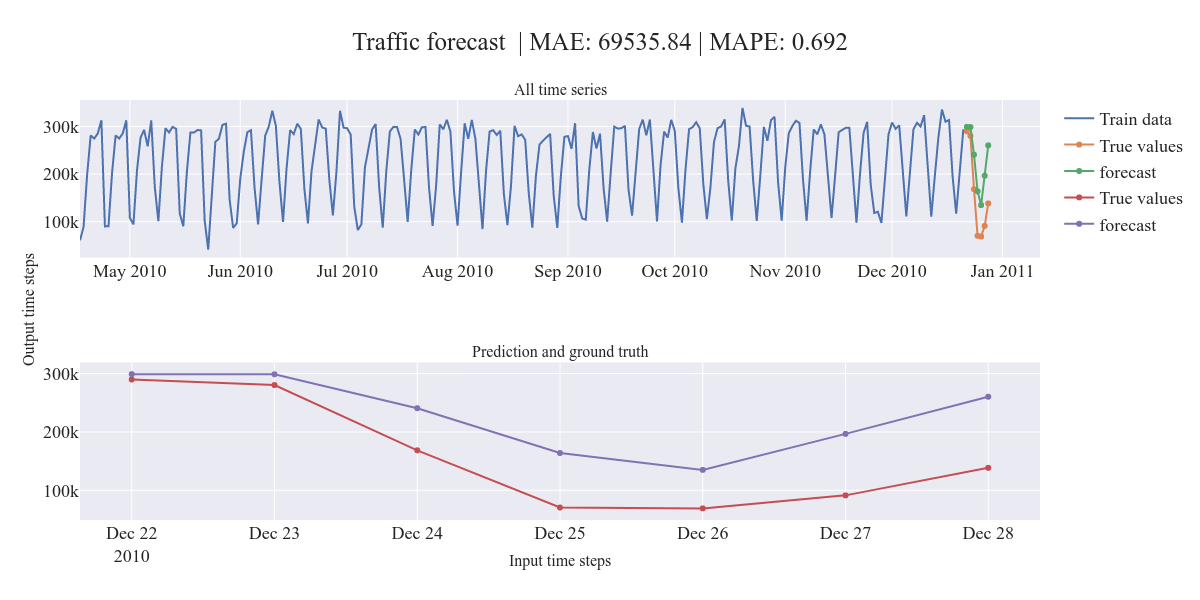

In [278]:
linear_fit_pred(last_train_set, last_test_set, exog=True, exog_cols=exog_cols, plot=True)

### 6.5 Escolhendo o melhor modelo modelo e importância das features <a name=imp></a>

Baseado nas metricas de teste final, o melhor modelo é a regressão linear, utilizando-se das entradas exogenas que geramos. Dessa forma vamos agora tentar entender o que o modelo acabou priorizando como feature para entende-lo melhor.

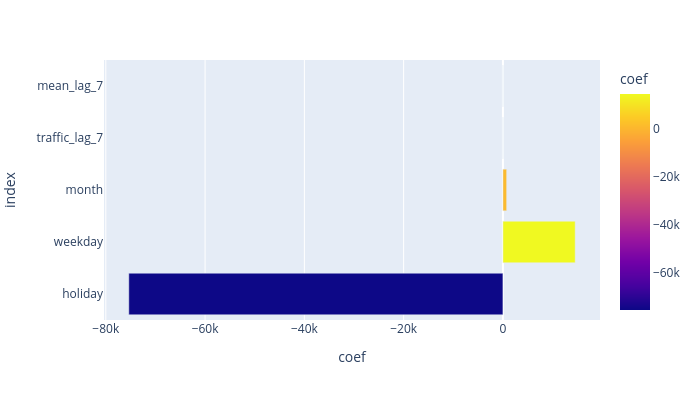

In [290]:
lr = LinearRegression()
lr.fit(last_train_set[exog_cols], last_train_set['traffic'])

coefs = pd.DataFrame(lr.coef_, last_train_set[exog_cols].columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs[np.abs(coefs)>0.1].sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
coefs = coefs.reset_index()
fig = px.bar(coefs, x='coef', y='index', color='coef',
                labels={'Mean value per quarter'}, height=400)
fig.show('png')

## 7. Considerações finais <a name=conclusao></a>

No presente relatório, construímos uma análise descritiva, exploratória e preditiva dos dados apresentados no desafio de ciência de dados da Radix. O problema proposto trata de registros de auditorias realizadas no metrô de Nova York, um os maiores e mais antigos do mundo, onde o objetivo é realizar previsões sobre o fluxo de passageiros do metrô. Foi nos dada a liberdade para escolher o período e variável a ser predita, assim como análise a ser desenvolvida. Optamos por uma análise diária do fluxo de passageiros (variável "traffic", criada a partir da soma de "entries" com "exits") para a estação com maior fluxo médio. Dentre os modelos apresentados, encontram-se:

- ARIMA
- LGBM
- Regressão linear
- Prophet

Com base nas métricas calculadas, concluímos que os três melhores modelos utilizados são:

1. Regressão linear
2. ARIMA

Também realizamos uma análise exploratória dos dados, identificando dias da semana com maior fluxo, assim como meses, e influência dos feriados, além de evidenciar as estações com maior tráfego.

### 7.1 Perpectivas <a name=perspectivas></a>

Como perspectivas elencamos:

- Explicar com maiores detalhes a teoria por trás de cada modelo;
- Realizar testes estatísticos para averiguar a influência de dias da semana e feriados sobre a distriuição dos dados;
- Aplicar a modelagem para toda a base de dados, inclusive de outros anos;
- Aplicar a modelagem para todas as estações.
